<a href="https://colab.research.google.com/github/vedanthshenoy/Infy-stock-price-prediction-BiLSTM/blob/main/infy_yahoo_finance_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data=pd.read_csv('/content/drive/MyDrive/INFY.csv',parse_dates=['Date'],index_col='Date')
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-11-30,8.320,8.500,8.225,8.340,7.163630,14280800
2015-12-01,8.350,8.385,8.205,8.280,7.112093,6067200
2015-12-02,8.210,8.225,8.110,8.130,6.983251,6377600
2015-12-03,8.140,8.150,8.035,8.065,6.927418,4031000
2015-12-04,8.065,8.215,8.060,8.185,7.030493,3501200


In [5]:
data['Day']=data.index.day
data['DayOfWeek']=data.index.dayofweek
data.head()

,Open,High,Low,Close,Adj Close,Volume,Day,DayOfWeek
Date,,,,,,,,
2015-11-30,8.320,8.500,8.225,8.340,7.163630,14280800,30,0
2015-12-01,8.350,8.385,8.205,8.280,7.112093,6067200,1,1
2015-12-02,8.210,8.225,8.110,8.130,6.983251,6377600,2,2
2015-12-03,8.140,8.150,8.035,8.065,6.927418,4031000,3,3
2015-12-04,8.065,8.215,8.060,8.185,7.030493,3501200,4,4


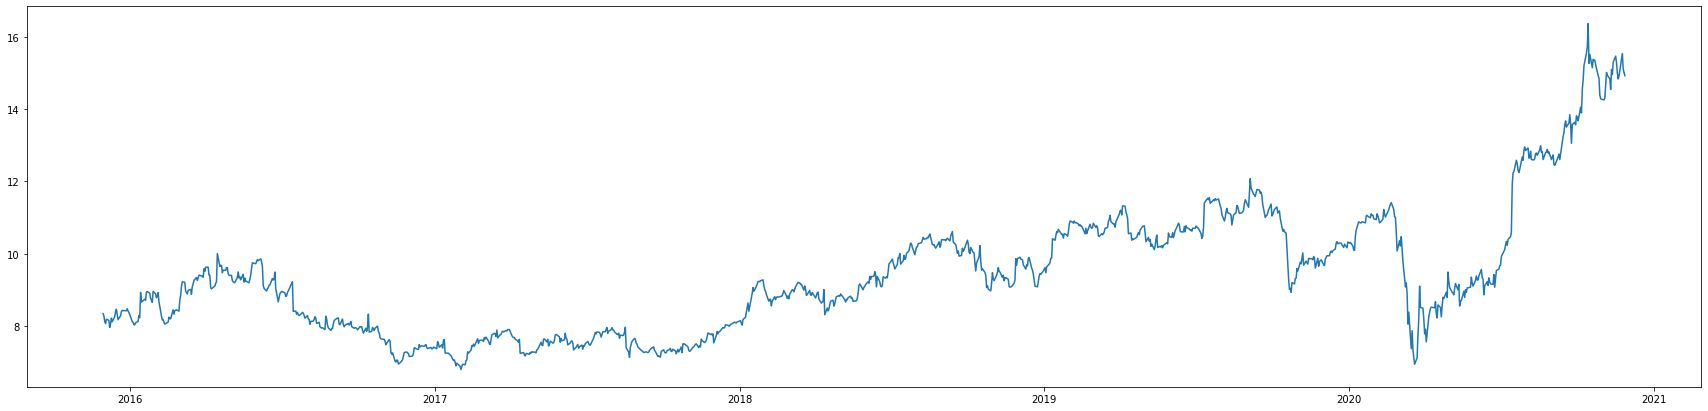

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,7))
plt.plot(data.index,data['Close'])
plt.show()

In [8]:
train_size=int(len(data)*0.9)
train,test=data.iloc[:train_size],data.iloc[train_size:len(data)]
train.shape,test.shape

((1133, 8), (126, 8))

In [9]:
from sklearn.preprocessing import MinMaxScaler

rs_data = MinMaxScaler()
rs_target = MinMaxScaler()

target=data['Close']
data.drop(columns=['Close'],inplace=True)

train.loc[:,data.columns]=rs_data.fit_transform(train.loc[:,data.columns].to_numpy())
train['Close']=rs_target.fit_transform(train[['Close']].to_numpy())
test.loc[:,data.columns]=rs_data.fit_transform(test.loc[:,data.columns].to_numpy())
test['Close']=rs_target.fit_transform(test[['Close']].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [10]:
import numpy as np
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [83]:
time_steps=6

x_train, y_train = create_dataset(train, train['Close'], time_steps)
x_test, y_test = create_dataset(test, train['Close'], time_steps)

x_train.shape,x_test.shape

((1127, 6, 8), (120, 6, 8))

In [84]:
import keras
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,return_sequences=True
    )
  ))
model.add(
  keras.layers.Bidirectional(
  keras.layers.LSTM(
  units=500,return_sequences=True
    )
  ))
model.add(
  keras.layers.Bidirectional(
  keras.layers.LSTM(units=500)
  )
)
model.add(keras.layers.Dropout(rate=0.25))
model.add(keras.layers.Dense(units=100,activation='relu'))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(units=1))
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mse"])

In [85]:
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.35,
    shuffle=False,
    verbose=1
)

Epoch 1/10
23/23 [==============================] - 10s 455ms/step - loss: 0.0152 - mse: 0.0303 - val_loss: 0.0148 - val_mse: 0.0295
Epoch 2/10
23/23 [==============================] - 8s 356ms/step - loss: 0.0154 - mse: 0.0307 - val_loss: 0.0081 - val_mse: 0.0163
Epoch 3/10
23/23 [==============================] - 8s 361ms/step - loss: 0.0206 - mse: 0.0412 - val_loss: 0.0435 - val_mse: 0.0870
Epoch 4/10
23/23 [==============================] - 8s 364ms/step - loss: 0.0120 - mse: 0.0239 - val_loss: 0.0195 - val_mse: 0.0390
Epoch 5/10
23/23 [==============================] - 8s 363ms/step - loss: 0.0116 - mse: 0.0232 - val_loss: 0.0064 - val_mse: 0.0128
Epoch 6/10
23/23 [==============================] - 8s 362ms/step - loss: 0.0134 - mse: 0.0268 - val_loss: 0.0443 - val_mse: 0.0885
Epoch 7/10
23/23 [==============================] - 8s 360ms/step - loss: 0.0135 - mse: 0.0271 - val_loss: 0.0086 - val_mse: 0.0171
Epoch 8/10
23/23 [==============================] - 8s 367ms/step - loss: 0

In [86]:
pred=model.predict(x_test)
y_train_inv=rs_target.inverse_transform(y_train.reshape(1,-1))
y_test_inv=rs_target.inverse_transform(y_test.reshape(1,-1))
pred=rs_target.inverse_transform(pred.reshape(1,-1))

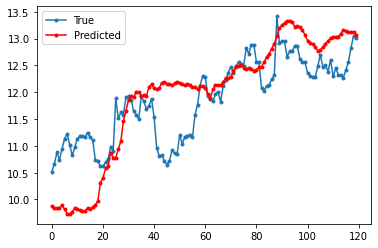

In [87]:
plt.plot(y_test_inv.flatten(),marker='.',label='True')
plt.plot(pred.flatten(),'r',marker='.',label='Predicted')
plt.legend()
plt.show()